In [4]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# === SETUP ===
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download NLTK data 
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/umang1607/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/umang1607/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# === FILE PATHS ===
ehr_path = "/Users/umang1607/Desktop/Mimic_modeling/combined_diseases.xlsx"
sym2d_path = "/Users/umang1607/Desktop/Mimic_modeling/Symptom2Disease.csv"
sym_train_path = "/Users/umang1607/Desktop/Mimic_modeling/symptom-disease-train-dataset.csv"
mapping_path = "/Users/umang1607/Desktop/Mimic_modeling/mapping.json"
synthetic_path = "/Users/umang1607/Desktop/Mimic_modeling/synthetic_symptoms.csv" 

# === TARGET DISEASES (normalize to canonical names) ===
canon_map = {
    "psoriasis": "Psoriasis",
    "pneumonia": "Pneumonia",
    "hemorrhoid": "Dimorphic Hemorrhoids",
    "arthritis": "Arthritis",
    "asthma": "Bronchial Asthma",
    "jaundice": "Jaundice",
    "urinary tract": "Urinary Tract Infection",
    "peptic ulcer": "Peptic Ulcer Disease",
    "diabetes": "Diabetes",
    "hypertension": "Hypertension",
    "heart failure": "Heart Failure",
    "kidney failure": "Kidney Failure"
}
target_diseases = list(canon_map.values())


In [3]:
# === 1️⃣ LOAD MAIN EHR FILE ===
df_ehr = pd.read_excel(ehr_path)
missing_cols = {'subject_id','gender','age','hadm_id','diagnosis_name','procedures','medications',
                'lab_test','lab_value','valueuom','lab_time','note_text','note_time'} - set(df_ehr.columns)
if missing_cols:
    print("WARNING: EHR file is missing columns:", missing_cols)

# Standardize diagnosis_name
def normalize_dx(name: str):
    if pd.isna(name):
        return name
    s = str(name).strip().lower()
    for k, v in canon_map.items():
        if k in s:
            return v
    return str(name).strip()

df_ehr['diagnosis_name'] = df_ehr['diagnosis_name'].apply(normalize_dx)
df_ehr = df_ehr[df_ehr['diagnosis_name'].isin(target_diseases)].copy()
df_ehr['note_text'] = df_ehr['note_text'].fillna("")

In [4]:
# === 2️⃣ LOAD & FILTER Symptom2Disease.csv ===
sym2d = pd.read_csv(sym2d_path)
sym2d['label'] = sym2d['label'].astype(str).str.strip()
sym2d['label_norm'] = sym2d['label'].str.lower().map({k: v for k, v in canon_map.items()})
sym2d.loc[sym2d['label_norm'].isna(), 'label_norm'] = sym2d.loc[sym2d['label_norm'].isna(), 'label'].apply(
    lambda x: canon_map.get(x.lower(), x))
sym2d = sym2d[sym2d['label_norm'].isin(target_diseases)].rename(columns={'label_norm': 'disease'})
sym2d = sym2d[['disease', 'text']].copy()

In [51]:
# === 2) LOAD & FILTER Symptom2Disease.csv (label, text) ===
sym2d = pd.read_csv(sym2d_path)

# === Add synthetic symptom text for Heart & Kidney Failure ===
synthetic_path = "/Users/umang1607/Desktop/Mimic_modeling/synthetic_symptoms.csv"  # update path if needed
synthetic_sym = pd.read_csv(synthetic_path)

# Standardize columns to match Symptom2Disease
synthetic_sym = synthetic_sym.rename(columns={'label': 'disease', 'symptom_text': 'text'})

# Merge synthetic data into the main Symptom2Disease dataset
sym2d = pd.concat([sym2d, synthetic_sym], ignore_index=True)

# Standardize labels
sym2d['label'] = sym2d['label'].astype(str).str.strip()
sym2d['label_norm'] = sym2d['label'].str.lower().map({k: v for k, v in canon_map.items()})
# Some labels may already be canonical-cased; try a fallback
sym2d.loc[sym2d['label_norm'].isna(), 'label_norm'] = sym2d.loc[sym2d['label_norm'].isna(), 'label'].apply(
    lambda x: canon_map.get(x.lower(), x)
)
sym2d = sym2d[sym2d['label_norm'].isin(target_diseases)].rename(columns={'label_norm':'disease'})
sym2d = sym2d[['disease','text']].copy()

In [5]:
# === 3️⃣ LOAD & FILTER symptom-disease-train-dataset.csv (+ mapping.json) ===
with open(mapping_path, 'r') as f:
    name_to_id = json.load(f)
id_to_name = {v: k for k, v in name_to_id.items()}

sym_train = pd.read_csv(sym_train_path)
sym_train['disease_name'] = sym_train['label'].map(id_to_name).astype(str)

def map_to_canon(name):
    low = name.strip().lower()
    for k, v in canon_map.items():
        if k in low:
            return v
sym_train['disease'] = sym_train['disease_name'].apply(map_to_canon)
sym_train = sym_train[sym_train['disease'].isin(target_diseases)].copy()

def comma_list_to_text(s):
    if pd.isna(s):
        return ""
    return " ".join([t.strip().replace("_"," ") for t in str(s).split(",") if t.strip()])

sym_train['text'] = sym_train['text'].apply(comma_list_to_text)
sym_train = sym_train[['disease', 'text']].copy()

In [6]:
# === 4️⃣ LOAD & MERGE SYNTHETIC SYMPTOM DATA ===
synthetic_sym = pd.read_csv(synthetic_path)
synthetic_sym.columns = synthetic_sym.columns.str.strip().str.lower()
synthetic_sym = synthetic_sym.rename(columns={'label': 'disease', 'symptom_text': 'text'})

synthetic_sym['disease'] = synthetic_sym['disease'].astype(str).str.strip().str.title()
synthetic_sym['text'] = synthetic_sym['text'].astype(str).str.strip()

def map_to_canon_label(disease):
    d = disease.lower()
    for k, v in canon_map.items():
        if k in d:
            return v
    return disease

synthetic_sym['disease'] = synthetic_sym['disease'].apply(map_to_canon_label)
synthetic_sym = synthetic_sym[synthetic_sym['disease'].isin(target_diseases)].copy()

# Merge synthetic with sym2d
sym2d = pd.concat([sym2d, synthetic_sym], ignore_index=True)
sym2d = sym2d[['disease', 'text']].dropna(subset=['disease', 'text'])
sym2d['disease'] = sym2d['disease'].astype(str).str.strip()
sym2d['text'] = sym2d['text'].astype(str).str.strip()

print("✅ Synthetic data merged successfully!")
print(sym2d['disease'].value_counts())

✅ Synthetic data merged successfully!
disease
Psoriasis                50
Pneumonia                50
Dimorphic Hemorrhoids    50
Arthritis                50
Bronchial Asthma         50
Hypertension             50
Jaundice                 50
Diabetes                 50
Heart Failure            25
Kidney Failure           25
Name: count, dtype: int64


In [7]:
# === 5️⃣ BUILD PER-DISEASE SYMPTOM CORPUS ===
corpus_from_sym2d = sym2d.groupby('disease')['text'].apply(lambda x: " ".join(map(str, x))).to_dict()
corpus_from_symtrain = sym_train.groupby('disease')['text'].apply(lambda x: " ".join(map(str, x))).to_dict()

disease_corpus = {d: "" for d in target_diseases}
for d in target_diseases:
    d_texts = []
    if d in corpus_from_sym2d:
        d_texts.append(corpus_from_sym2d[d])
    if d in corpus_from_symtrain:
        d_texts.append(corpus_from_symtrain[d])
    disease_corpus[d] = " ".join(d_texts).strip()

# Assign random symptom text per patient
disease_sym_map = sym2d.groupby("disease")["text"].apply(list).to_dict()

def random_symptom(disease):
    disease = str(disease).strip()
    if disease in disease_sym_map:
        return np.random.choice(disease_sym_map[disease], replace=True)
    return ""

df_ehr["symptom_text"] = df_ehr["diagnosis_name"].apply(random_symptom)
df_ehr["text_all"] = (df_ehr["note_text"].astype(str) + " " + df_ehr["symptom_text"].astype(str)).str.strip()

print("✅ Randomized symptom text assigned per patient.")
print(df_ehr[["diagnosis_name", "symptom_text"]].head(10))

✅ Randomized symptom text assigned per patient.
  diagnosis_name                                       symptom_text
0      Psoriasis  I am worried about the constant peeling of the...
1      Psoriasis  Because of dry, flaky areas on my skin, I am p...
2      Psoriasis  The skin on my palms and soles is thickened an...
3      Psoriasis  Because of dry, flaky areas on my skin, I am p...
4      Psoriasis  I've had trouble falling asleep because of the...
5      Psoriasis  I've had trouble sleeping because of the itchi...
6      Psoriasis  I've had trouble sleeping because of the itchi...
7      Psoriasis  There is a silver like dusting on my skin. Mor...
8      Psoriasis  For the past few weeks, I've had a skin rash o...
9      Psoriasis  The skin around my mouth, nose, and eyes is re...


In [9]:
pd.set_option('display.max_colwidth', None)

for disease, group in df_ehr.groupby("diagnosis_name"):
    print(f"\n===== {disease.upper()} =====")
    print(group["symptom_text"].dropna().unique()[:10])  # show up to 5 unique symptom lines


===== ARTHRITIS =====
[np.str_("I've been experiencing stiffness and weakness in my neck muscles recently. Since my joints have grownup, it's onerous on behalf of me to run while not obtaining stiff. in addition, walking has been extraordinarily uncomfortable.")
 np.str_("Recently, I've been suffering neck muscle weakness and stiffness. My joints have enlarged and it is difficult for me to walk without feeling stiff. Walking has also been excruciatingly uncomfortable.")
 np.str_("My muscles have been feeling really weak, and my neck has been extremely tight. I've been experiencing a lot of stiffness when I walk about and my joints have been swollen. Walking has also been really uncomfortable.")
 np.str_('My muscles have been feeling really weak, and my neck has been extremely tight. My joints have swollen, making it difficult for me to move. It has hurt a lot to walk.')
 np.str_("I've been experiencing muscular weakness and stiffness in my neck recently. My joints have swollen, creati

In [11]:
# Save merged file
out_csv = "combined_with_symptoms.csv"
df_ehr.to_csv(out_csv, index=False)
print(f"✅ Saved merged file -> {out_csv}   rows={len(df_ehr)}")

✅ Saved merged file -> combined_with_symptoms.csv   rows=18000


In [12]:
# === 5) BASIC STRUCTURED FEATURES (age, gender; plus simple lab aggregation) ===
# Gender standardize
df_ehr['gender'] = df_ehr['gender'].astype(str).str.upper().replace({'MALE':'M','FEMALE':'F'})

# Aggregate labs per (subject_id, hadm_id)
lab_agg = (df_ehr.groupby(['subject_id','hadm_id','lab_test'])['lab_value']
           .agg(['mean','min','max']).reset_index())
lab_pivot = lab_agg.pivot_table(index=['subject_id','hadm_id'],
                                columns='lab_test',
                                values=['mean','min','max'])
lab_pivot.columns = ['_'.join(col).strip() for col in lab_pivot.columns.values]
lab_pivot = lab_pivot.reset_index()

# Deduplicate EHR core
core = df_ehr[['subject_id','hadm_id','age','gender','diagnosis_name','procedures','medications','text_all']].drop_duplicates(
    subset=['subject_id','hadm_id']
)
X = core.merge(lab_pivot, on=['subject_id','hadm_id'], how='left')

# Target
y = X['diagnosis_name'].copy()

In [13]:
core

subject_id   hadm_id  age gender  diagnosis_name  \
0        10004720  22081550   61      M       Psoriasis   
1        10007920  22218665   52      M       Psoriasis   
2        10022041  28909879   64      M       Psoriasis   
4        10042769  25990801   91      M       Psoriasis   
6        10088914  22311401   82      M       Psoriasis   
...           ...       ...  ...    ...             ...   
17990    19940147  20655019   57      F  Kidney Failure   
17991    19948815  20319869   49      F  Kidney Failure   
17992    19957410  23037934   64      F  Kidney Failure   
17993    19965625  26179795   82      F  Kidney Failure   
17996    19971771  26230047   83      F  Kidney Failure   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         procedures  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Respiratory Ventilation, Greater than 96 Consecutive Hours, Drainage of Right Pleural Cavity with Drainage Device, Percutaneous Approach, Insertion of Infusion Device into Right Atrium, Percutaneous Approach, Introduction of Nutritional Substance into Upper GI, Via Natural or Artificial Opening   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               NaN   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [14]:
# === 6) TEXT CLEANING (lowercase, keep letters, lemmatize, stopword filter) ===
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r'[^a-z\s]', ' ', s)
    tokens = [w for w in s.split() if w not in stop and len(w) > 2]
    lemmas = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmas)

X['text_clean'] = X['text_all'].fillna("").apply(clean_text)

In [15]:
# === 7) FEATURE SPLIT ===
text_col = 'text_clean'
cat_cols  = ['gender']        
num_cols  = ['age'] + [c for c in X.columns if c.startswith(('mean_','min_','max_'))]

# Impute numeric (median)
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce')
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# One-hot categorical
X[cat_cols] = X[cat_cols].fillna('Unknown')

# Train/test split (stratified)
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X[[text_col] + cat_cols + num_cols],
    y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

In [16]:
X

subject_id   hadm_id  age gender  diagnosis_name  \
0       10004720  22081550   61      M       Psoriasis   
1       10007920  22218665   52      M       Psoriasis   
2       10022041  28909879   64      M       Psoriasis   
3       10042769  25990801   91      M       Psoriasis   
4       10088914  22311401   82      M       Psoriasis   
...          ...       ...  ...    ...             ...   
8546    19940147  20655019   57      F  Kidney Failure   
8547    19948815  20319869   49      F  Kidney Failure   
8548    19957410  23037934   64      F  Kidney Failure   
8549    19965625  26179795   82      F  Kidney Failure   
8550    19971771  26230047   83      F  Kidney Failure   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        procedures  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Respiratory Ventilation, Greater than 96 Consecutive Hours, Drainage of Right Pleural Cavity with Drainage Device, Percutaneous Approach, Insertion of Infusion Device into Right Atrium, Percutaneous Approach, Introduction of Nutritional Substance into Upper GI, Via Natural or Artificial Opening   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              NaN   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [17]:
# === 8) VECTORIZERS / TRANSFORMERS ===
# Text: TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Categorical+Numeric preprocessing via ColumnTransformer
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False for sparse safety
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Fit text on train
X_train_text = tfidf.fit_transform(X_train[text_col])
X_test_text  = tfidf.transform(X_test[text_col])

# Build structured matrix
ct = ColumnTransformer(
    transformers=[
        ('cats', cat_transformer, cat_cols),
        ('nums', num_transformer, num_cols)
    ],
    remainder='drop'
)

X_train_struct = ct.fit_transform(X_train)
X_test_struct  = ct.transform(X_test)

# Combine text + structured
from scipy.sparse import hstack
Xtr = hstack([X_train_text, X_train_struct])  # train features
Xte = hstack([X_test_text,  X_test_struct])   # test  features

In [18]:
# === 9) MODELS ===
# Logistic Regression
lr = LogisticRegression(
    max_iter=1500,
    class_weight='balanced',
    solver='lbfgs',
    multi_class='multinomial',
    n_jobs=-1
)
lr.fit(Xtr, y_train)
y_pred_lr = lr.predict(Xte)
y_prob_lr = lr.predict_proba(Xte)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
auroc_lr = roc_auc_score(y_test, y_prob_lr, multi_class='ovr', average='macro')

print(f"\nLogistic Regression  ->  F1 (macro): {f1_lr:.4f} | AUROC (macro): {auroc_lr:.4f}")

/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression  ->  F1 (macro): 0.7817 | AUROC (macro): 0.9642


/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Random Forest
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=24,
    min_samples_leaf=3,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf.fit(Xtr, y_train)
y_pred_rf = rf.predict(Xte)
y_prob_rf = rf.predict_proba(Xte)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
auroc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr', average='macro')

print(f"Random Forest       ->  F1 (macro): {f1_rf:.4f} | AUROC (macro): {auroc_rf:.4f}")


Random Forest       ->  F1 (macro): 0.8776 | AUROC (macro): 0.9847


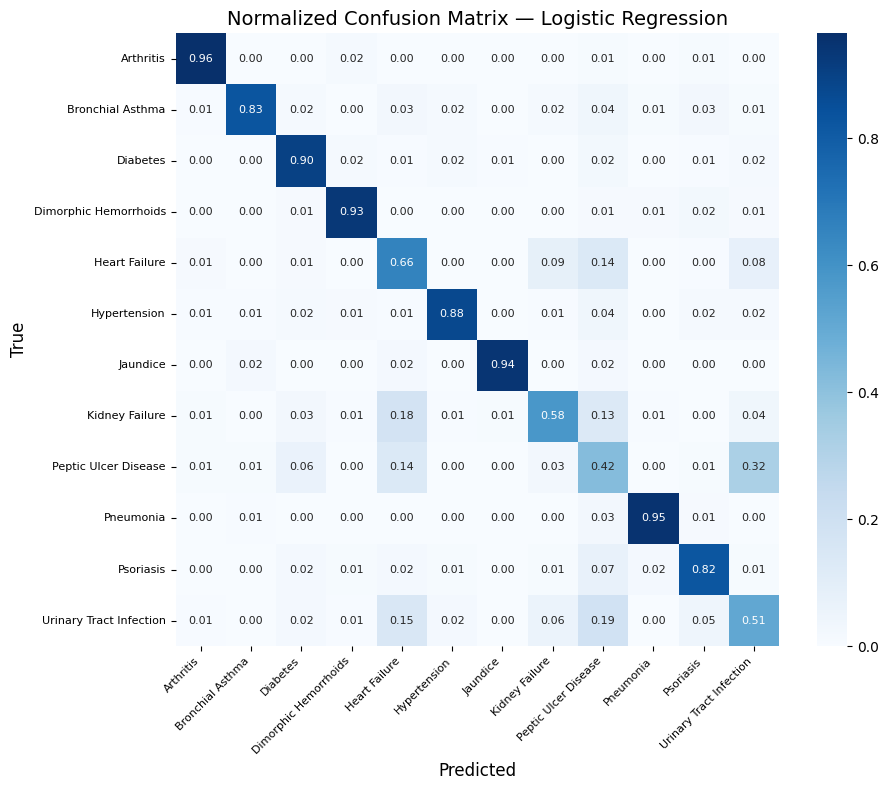

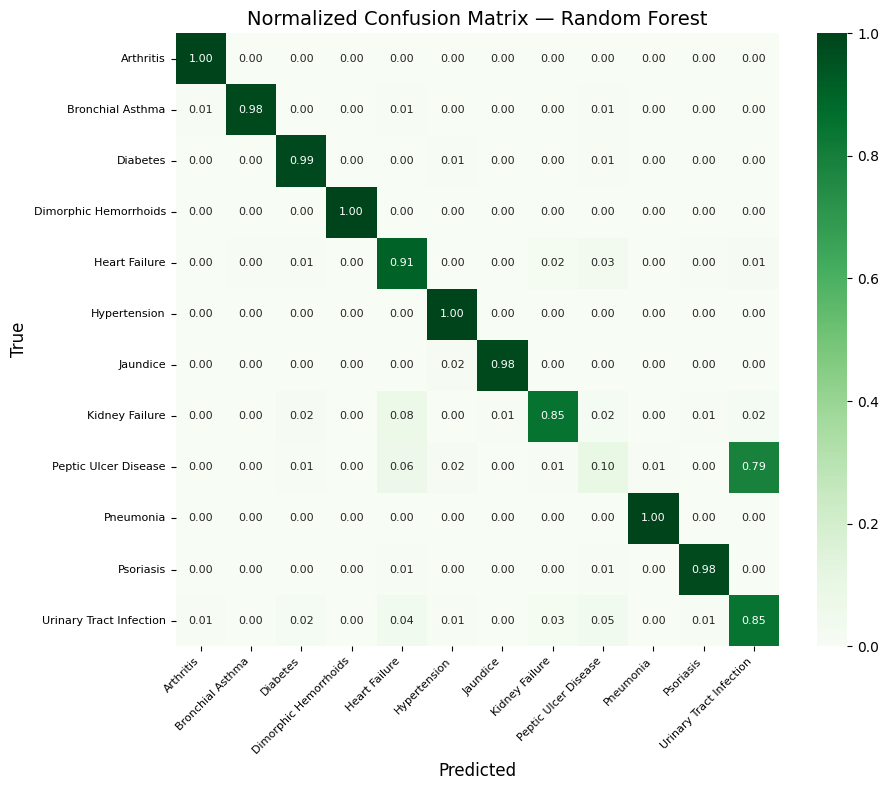

In [29]:
# ===10) CONFUSION MATRICES ===
def plot_cm(y_true, y_pred, labels, title, cmap):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(9.5, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap,
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 8})
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

class_names = list(le.classes_)
plot_cm(y_test, y_pred_lr, class_names, "Normalized Confusion Matrix — Logistic Regression", "Blues")
plot_cm(y_test, y_pred_rf, class_names, "Normalized Confusion Matrix — Random Forest", "Greens")

In [22]:
# === 9) MODELS ===
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# --- Naive Bayes (MultinomialNB) ---
nb = MultinomialNB()
nb.fit(Xtr, y_train)
y_pred_nb = nb.predict(Xte)
y_prob_nb = nb.predict_proba(Xte)
f1_nb = f1_score(y_test, y_pred_nb, average='macro')
auroc_nb = roc_auc_score(y_test, y_prob_nb, multi_class='ovr', average='macro')

print(f"Naive Bayes          ->  F1 (macro): {f1_nb:.4f} | AUROC (macro): {auroc_nb:.4f}")

Naive Bayes          ->  F1 (macro): 0.4208 | AUROC (macro): 0.8703


In [23]:
# --- Support Vector Machine (Linear SVM with probability calibration) ---
svm = LinearSVC(class_weight='balanced', max_iter=3000)
svm_cal = CalibratedClassifierCV(svm, method='sigmoid', cv=3)
svm_cal.fit(Xtr, y_train)
y_pred_svm = svm_cal.predict(Xte)
y_prob_svm = svm_cal.predict_proba(Xte)
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
auroc_svm = roc_auc_score(y_test, y_prob_svm, multi_class='ovr', average='macro')

print(f"SVM (LinearSVC)      ->  F1 (macro): {f1_svm:.4f} | AUROC (macro): {auroc_svm:.4f}")

/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM (LinearSVC)      ->  F1 (macro): 0.8279 | AUROC (macro): 0.9784


/opt/homebrew/Cellar/jupyterlab/4.4.9/libexec/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
# --- Summary Table ---
import pandas as pd
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM (Linear)', 'Random Forest'],
    'F1 (macro)': [f1_lr, f1_nb, f1_svm,  f1_rf],
    'AUROC (macro)': [auroc_lr, auroc_nb, auroc_svm, auroc_rf]
})
print("\n=== Model Comparison ===")
print(results)


=== Model Comparison ===
                 Model  F1 (macro)  AUROC (macro)
0  Logistic Regression    0.781711       0.964170
1          Naive Bayes    0.420786       0.870336
2         SVM (Linear)    0.827885       0.978412
3        Random Forest    0.877591       0.984677


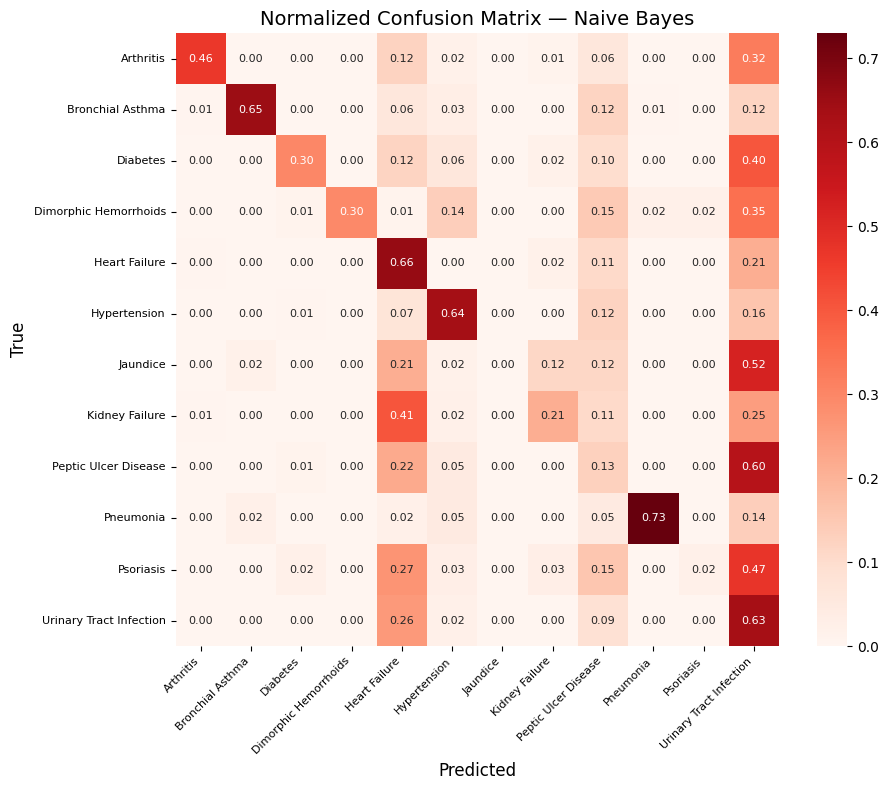

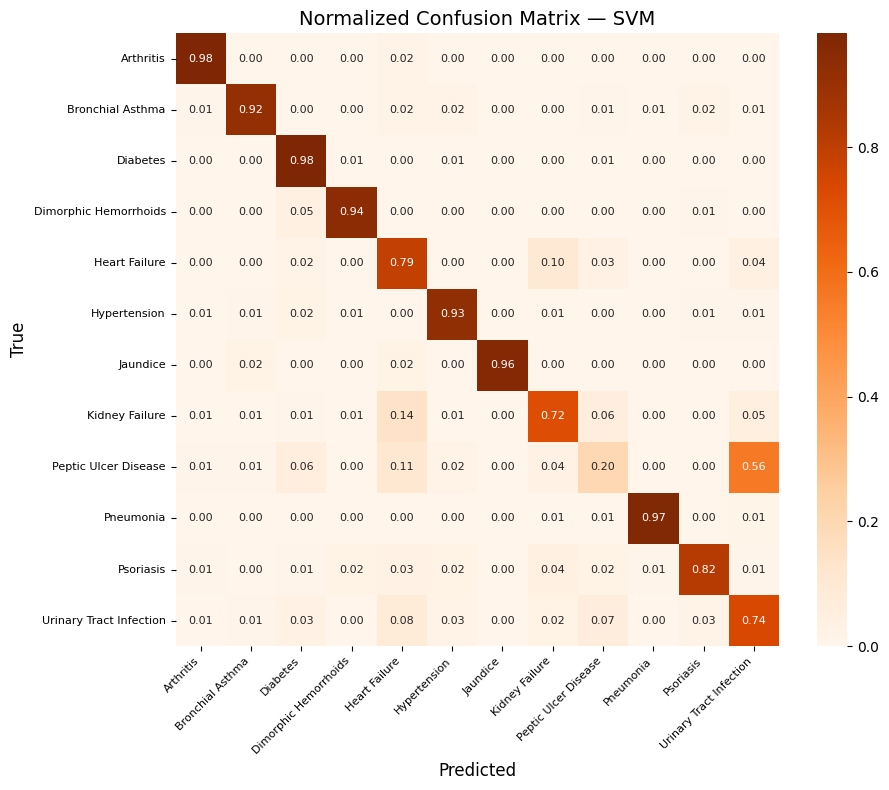

In [30]:
plot_cm(y_test, y_pred_nb, class_names, "Normalized Confusion Matrix — Naive Bayes", "Reds")
plot_cm(y_test, y_pred_svm, class_names, "Normalized Confusion Matrix — SVM", "Oranges")